## Modeling scATAC-seq data with mubind (PBMC, 10x)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [3]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../../../../annotations'
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [4]:
import scanpy as sc

In [5]:
# create a backup with neighbors+umap included
atac_datadir = '../../../../atac_poisson_study/data'
adata_updated_path = os.path.join(atac_datadir, '10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix_with_umap.h5ad')
if not os.path.exists(adata_updated_path):
    adata = mb.bindome.datasets.scATAC.PBMCs_10x_v2(datadir=atac_datadir)
    peak_ids = adata.var_names
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    adata.write(adata_updated_path, compression='lzf')
adata = sc.read_h5ad(adata_updated_path)


In [8]:
adata.layers['counts'] = adata.X

In [9]:
sc.tl.leiden(adata)

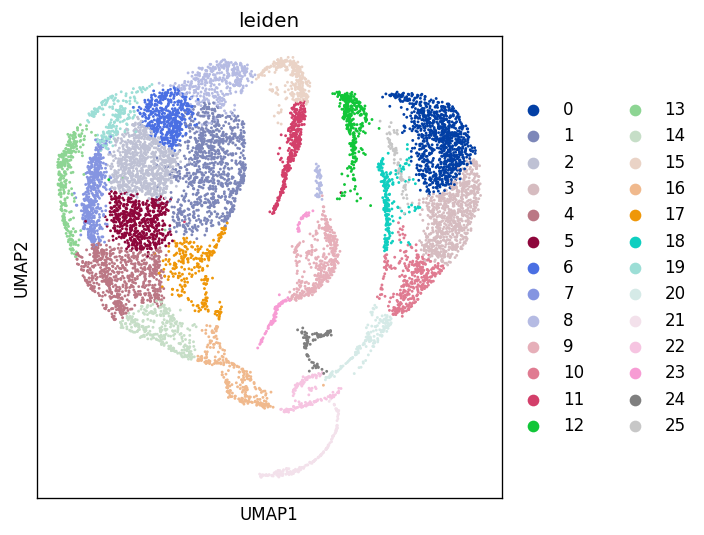

In [10]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 120})
sc.pl.umap(adata, color='leiden')

In [11]:
adata= adata[:,adata.var.chr == 'chr11'].copy()

In [13]:
# ad = mb.pp.sample_anndata(adata, n_sample_obs=500, n_sample_var=500) # adata.shape[0], n_sample_var=adata.shape[1])
# ad.shape

In [31]:
ad = adata.copy()


(10246, 7791)

In [32]:
ad = ad[ad.X.sum(axis=1) != 0, ad.X.sum(axis=0) != 0].copy()
ad.shape

(10246, 7791)

### This extension is needed to make peaks homogeneous, and avoid long peaks

In [33]:
extend = 50
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'].astype(str) + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)
ad.shape

(10246, 7791)

### Get sequences from fasta files

In [34]:
ad

AnnData object with n_obs × n_vars = 10246 × 7791
    obs: 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'chr', 'start', 'end', 'peak.length', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [35]:
# focus on a specific chromsome
gen_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'hg38/genome/chr11.fa')
os.path.exists(gen_path)

True

In [36]:
len(ad.var_names)

7791

In [37]:
use_bedtools = True
if not use_bedtools:
    hs_fastas = bd.tl.get_fastas(gen_path)
    print('here...')
    seqs = []
    for ri, r in ad.var.iterrows():
        i, j = r['start'], r['end']
        s = hs_fastas[0][1][i: j].upper()
        seqs.append(s)
else:
    n_seqs = min(len(ad.var_names), 200)# adata.shape[1] # None # 1000
    print(n_seqs)
    seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs),
                                                genome='hg38', uppercase=True,
                                                bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools',
                                                overwrite=True, log=True, gen_path=gen_path)
    keys = set([s[0] for s in seqs])
    ad = ad[:,ad.var['k.summit'].isin(keys)]

    seqs = [s[1] for s in seqs]
    # seqs = [[s[0], s[1].upper()] for s in seqs[0]]

200
/tmp/tmpptcmy_3t
genome hg38 False
../../../../../../annotations/hg38/genome/chr11.fa
True ../../../../../../annotations/hg38/genome/chr11.fa
running bedtools...
['/home/ilibarra/.conda/envs/mubind/bin/bedtools', 'getfasta', '-fi', '../../../../../../annotations/hg38/genome/chr11.fa', '-bed', '/tmp/tmpptcmy_3t', '-fo', '/tmp/tmpja3ij32g']
/home/ilibarra/.conda/envs/mubind/bin/bedtools getfasta -fi ../../../../../../annotations/hg38/genome/chr11.fa -bed /tmp/tmpptcmy_3t -fo /tmp/tmpja3ij32g


### Preparation of training data

In [38]:
len(seqs)

200

In [40]:
# use the raw counts across cells
next_data = pd.DataFrame(ad.X.T.A) # sparse.from_spmatrix(counts.A)
next_data['var'] = next_data.var(axis=1)
print(next_data.shape, len(seqs))
next_data.index = seqs
next_data.index.name = 'seq'
print(next_data.shape)

(200, 10247) 200
(200, 10247)


In [41]:


# selection of cells based on overall var score
n_cells = 1000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
next_data_sel
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']
df = next_data_sel.copy() # sample
print(next_data_sel.shape)


(200, 10246)


In [42]:
# enr series = False indicates that everything is independent.
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)

In [43]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)

In [44]:
device

device(type='cuda', index=0)

In [45]:
criterion = mb.tl.PoissonLoss()
n_kernels = 2
w = [20 for r in range(n_kernels)]
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=True,
                                       use_dinuc=False,
                                       device=device,
                                       prepare_knn=True,
                                       adata=ad,
                                       dinuc_mode=None) # .cuda()


setting up log dynamic


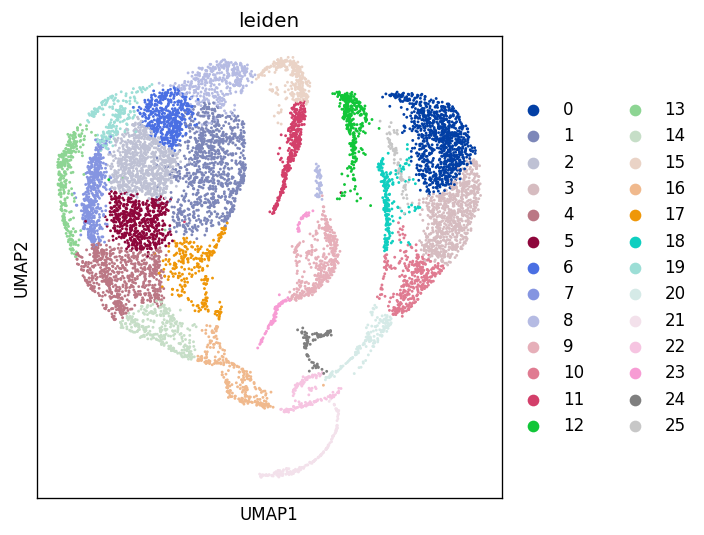

In [46]:
sc.pl.umap(ad, color='leiden')

In [47]:
# model = model.cuda()

In [48]:
import torch.optim as topti


In [49]:
import warnings
warnings.filterwarnings("ignore")

In [50]:
model

Mubind(
  (padding): ConstantPad2d(padding=(19, 19, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2-3): 2 x Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x10246 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 1x10246 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 1x10246 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 1x10246 (cuda:0)]
    )
  )
  (graph_module): GraphModule()
  (criterion): PoissonLoss()
)

In [51]:
model, best_loss = model.optimize_iterative(train, n_epochs=[50, 20, 20, 20],
                                            show_logo=False,
                                            use_mono=True,
                                            use_dinuc=False,
                                            dinuc_mode='local',
                                            opt_kernel_shift=[0, 0, 0, 0],
                                            opt_kernel_length=[0, 0, 0, 0],
                                            shift_max=1,
                                            shift_step=1,
                                            optimiser=topti.Adam,
                                            # skip_kernels=range(2, 4),
                                            n_batches=1,
                                            n_rounds=df.shape[1],
                                            num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20, 20],
                                            r2_per_epoch=True,
                                            early_stopping=50,
                                            log_each=10,
                                            w=25,
                                            max_w=25) #  target_dim=train.dataset.signal.shape[1])

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 22%|██████████████████████████████████████████▏                                                                                                                                                     | 11/50 [02:13<09:26, 14.54s/it]

Epoch: 11, Loss: 10502.858537, R2: 0.33,  best epoch: 9,  secs per epoch: 13.343 s,  secs epoch*1k trials: 66.717s curr time: 2024-04-10 20:02:37.591386


 42%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 21/50 [04:29<08:01, 16.61s/it]

Epoch: 21, Loss: 4829.349777, R2: 0.34,  best epoch: 19,  secs per epoch: 13.457 s,  secs epoch*1k trials: 67.283s curr time: 2024-04-10 20:04:53.288411


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 31/50 [06:57<05:39, 17.89s/it]

Epoch: 31, Loss: 2014.213253, R2: 0.35,  best epoch: 29,  secs per epoch: 13.931 s,  secs epoch*1k trials: 69.656s curr time: 2024-04-10 20:07:22.092581


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 41/50 [09:15<02:27, 16.36s/it]

Epoch: 41, Loss: 799.946725, R2: 0.36,  best epoch: 39,  secs per epoch: 13.881 s,  secs epoch*1k trials: 69.406s curr time: 2024-04-10 20:09:39.408290


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:09<00:00, 13.39s/it]


Final loss: 373.2010053645 , R2: 0.37
Total time (model/function): (669.314s / 669.314s)
Time per epoch (model/function): (13.659s/ 13.659s)
Time per epoch per 1k trials: 68.297s
Current time: 2024-04-10 20:11:44.509022
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 1 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 1 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 20 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 11/20 [02:49<02:56, 19.59s/it]

Epoch: 11, Loss: 143.961851, R2: 0.37,  best epoch: 9,  secs per epoch: 16.908 s,  secs epoch*1k trials: 84.541s curr time: 2024-04-10 20:14:33.592545


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:08<00:00, 15.43s/it]


Final loss: 138.9929869359 , R2: 0.38
Total time (model/function): (977.920s / 308.606s)
Time per epoch (model/function): (51.469s/ 16.242s)
Time per epoch per 1k trials: 81.212s
Current time: 2024-04-10 20:17:04.290418


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 20 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 11/20 [02:14<02:13, 14.89s/it]

Epoch: 11, Loss: 3.480358, R2: 0.38,  best epoch: 7,  secs per epoch: 13.468 s,  secs epoch*1k trials: 67.340s curr time: 2024-04-10 20:19:18.971389


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.65s/it]


Final loss: 1.3615634768 , R2: 0.38
Total time (model/function): (1211.018s / 233.098s)
Time per epoch (model/function): (63.738s/ 12.268s)
Time per epoch per 1k trials: 61.342s
Current time: 2024-04-10 20:21:07.454077
best loss 1.2804071509296087
current r2 values by newly added filter
[0.3817507829010327]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 2 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 2 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 20 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 11/20 [02:06<02:06, 14.04s/it]

Epoch: 11, Loss: 125.295960, R2: 0.38,  best epoch: 7,  secs per epoch: 12.667 s,  secs epoch*1k trials: 63.336s curr time: 2024-04-10 20:23:23.644659


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:36<00:00, 10.82s/it]


Final loss: 122.9908667955 , R2: 0.38
Total time (model/function): (1427.386s / 216.368s)
Time per epoch (model/function): (75.126s/ 11.388s)
Time per epoch per 1k trials: 56.939s
Current time: 2024-04-10 20:25:02.670259


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 20 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 11/20 [01:53<01:53, 12.60s/it]

Epoch: 11, Loss: 3.701642, R2: 0.38,  best epoch: 7,  secs per epoch: 11.356 s,  secs epoch*1k trials: 56.782s curr time: 2024-04-10 20:26:56.237034


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:15<00:00,  9.80s/it]


Final loss: 1.5514847583 , R2: 0.39
Total time (model/function): (1623.376s / 195.990s)
Time per epoch (model/function): (85.441s/ 10.315s)
Time per epoch per 1k trials: 51.576s
Current time: 2024-04-10 20:28:27.971231
best loss 0.66283304043009
current r2 values by newly added filter
[0.3817507829010327, 0.3849803274752335]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 3 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 3 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 20 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 11/20 [01:48<01:47, 12.00s/it]

Epoch: 11, Loss: 119.628485, R2: 0.39,  best epoch: 7,  secs per epoch: 10.886 s,  secs epoch*1k trials: 54.432s curr time: 2024-04-10 20:30:25.111516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:09<00:00,  9.46s/it]


Final loss: 116.9165068583 , R2: 0.39
Total time (model/function): (1812.564s / 189.188s)
Time per epoch (model/function): (95.398s/ 9.957s)
Time per epoch per 1k trials: 49.786s
Current time: 2024-04-10 20:31:54.887964


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 20 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 11/20 [01:47<01:48, 12.04s/it]

Epoch: 11, Loss: 3.768090, R2: 0.39,  best epoch: 7,  secs per epoch: 10.754 s,  secs epoch*1k trials: 53.772s curr time: 2024-04-10 20:33:42.433844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.41s/it]


Final loss: 1.4937771544 , R2: 0.39
Total time (model/function): (2000.777s / 188.213s)
Time per epoch (model/function): (105.304s/ 9.906s)
Time per epoch per 1k trials: 49.530s
Current time: 2024-04-10 20:35:12.302631
best loss 0.6424223187022113
current r2 values by newly added filter
[0.3817507829010327, 0.3849803274752335, 0.38586128694513133]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 2000.7774662971497s
Time per epoch (total): 18.189 s


In [52]:
r2 = mb.tl.scores(model, train, by='batch')
print("R^2:", r2)


R^2: {0: {'r2_counts': 0.3858612868754231, 'r2_foldchange': 0.0441996526321361, 'r2_enr': 0.03892657716732395, 'r2_fc': 0.05437416991458735, 'pearson_foldchange': 0.23318269643047562}}


True
2
order None
0 out of 4...


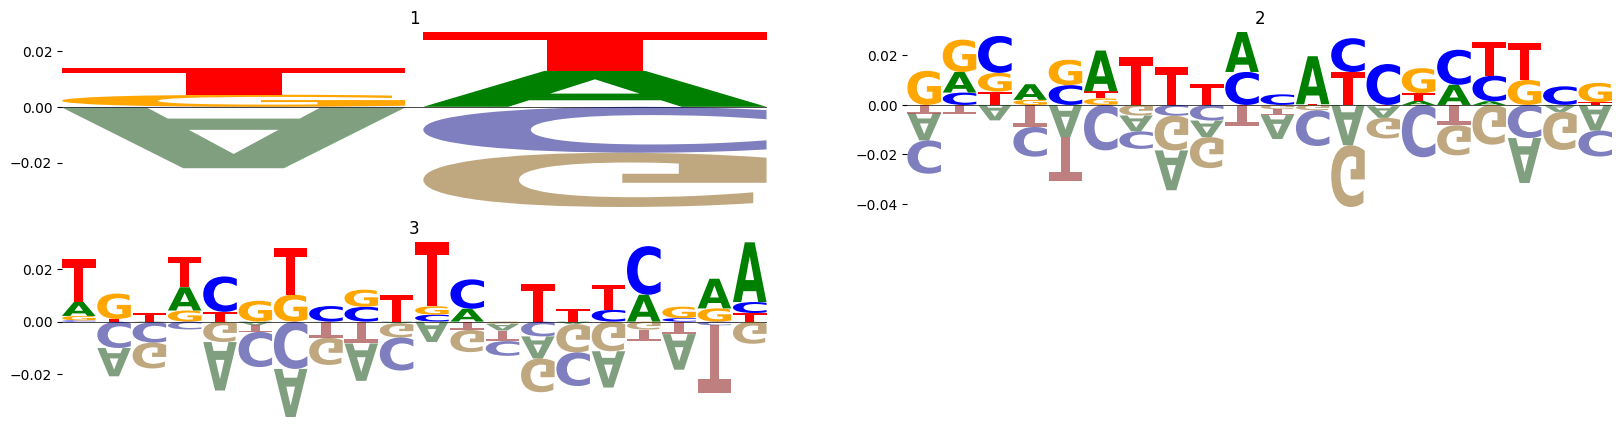

In [53]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.logo(model, n_cols=2, show=True)
plt.show()


### Here we attempt to visualize the log_dynamic scores

<Axes: xlabel='index', ylabel='r2'>

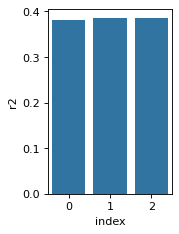

In [54]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [55]:
# dyn_score
dyn_score = mb.tl.dynamic_score(model)
dyn_score_scaled = (dyn_score - dyn_score.min()) / (dyn_score.max() - dyn_score.min())
ad.obs['dynamic_score'] = dyn_score_scaled

Text(0.5, 7.555555555555548, 'dynamic score (normalized)')

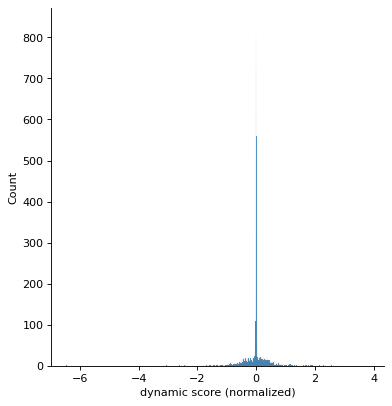

In [56]:
ad.obs['dynamic_score_cluster'] = np.where(dyn_score_scaled > dyn_score_scaled.mean(), 'dynamic', 'static')
mu, sigma = dyn_score.mean(), dyn_score.std()
zscore = ((dyn_score - mu) / sigma)
z1 = np.where(zscore > 1, 'dynamic', 'static')
z2 = np.where(zscore > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dyn_score)
plt.xlabel('dynamic score (normalized)')


In [57]:
sc.tl.umap(ad)

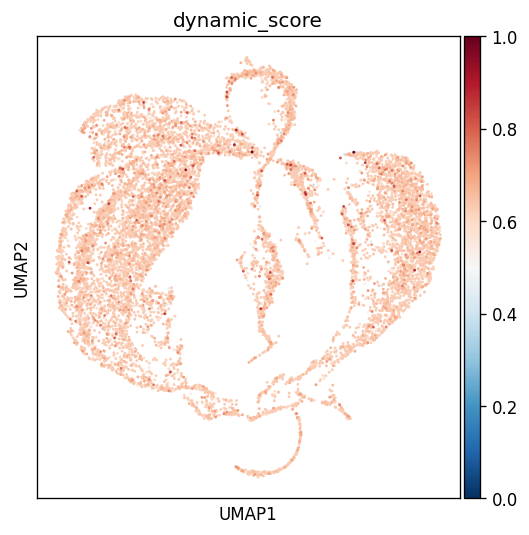

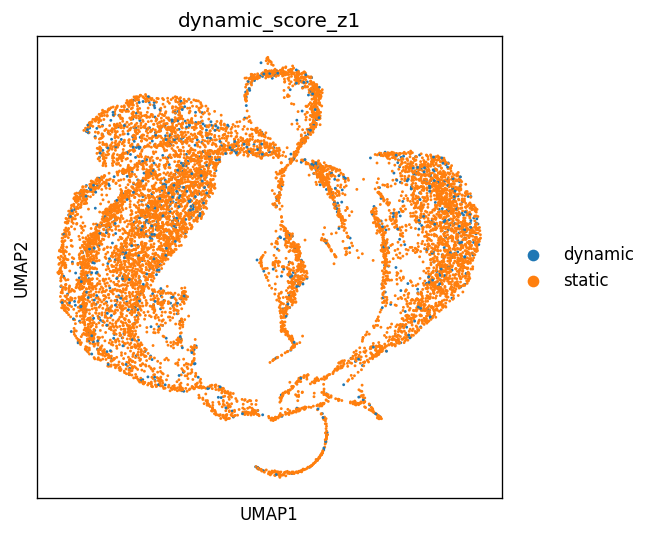

In [58]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [59]:
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')

In [60]:
# sc.pl.embedding_density?

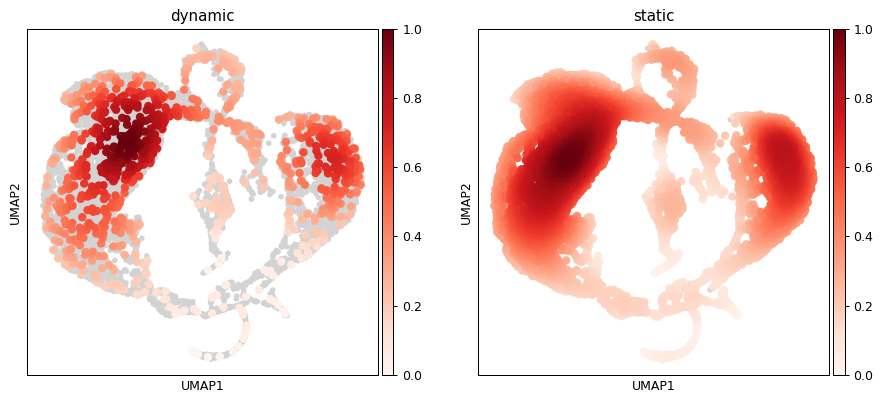

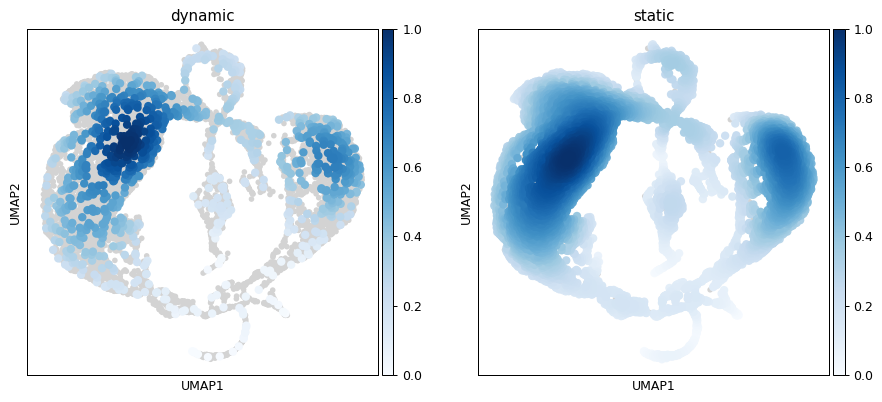

In [61]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group=['dynamic', 'static'], color_map='Reds') # basis='umap', groupby='dynamic_score_cluster')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group=['dynamic', 'static'], color_map='Blues') # basis='umap', groupby='dynamic_score_cluster')
# sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

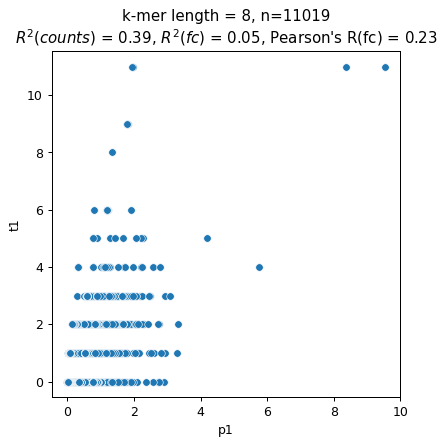

{'r2_counts': 0.3858612868064052,
 'r2_foldchange': 0.04419964577656721,
 'r2_enr': 0.03892657380749476,
 'r2_fc': 0.054374171699087606,
 'pearson_foldchange': 0.233182700256875}

In [62]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

True
12
order None
0 out of 4...


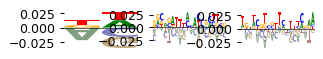

In [63]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))


In [64]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 10.817836
